In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Working with PyTorch
- multi-class output
- Ionosphere
- Regularization
- Dropout


In [2]:
import os
#import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'ionosphere'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 500 # number of epochs

ALPHA = 0.001 # learning rate
WEIGHT_DECAY = 0.001 # Weight decay

BATCH_SIZE = 16

TRAIN_SIZE = int(BATCH_SIZE *17)
PATIENCE = 30
LR_FACTOR=0.1
LR_PATIENCE=10
 
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }


CMAP = plt.cm.brg

plt.rcParams.update(params)

In [4]:
# 351 * 0.8 / 16 = 17.55

# 351 - 17 * 16 = 79

## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [6]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [7]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

In [8]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  False
CUDA version:  None


In [9]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [10]:
train_df, test_df = train_test_split(data_df, 
                                     train_size=TRAIN_SIZE,
                                     random_state=RANDOM_STATE,
                                     stratify= data_df[data_df.columns[-1]])
train_df.shape, test_df.shape

((272, 35), (79, 35))

In [11]:
'''Using Singleton design pattern'''
''' Singleton Design Pattern: '''

class Transformers:
    '''
    Args:
        has one standard scaler and 2 label encoder.
    '''
    _instance = None
    
    def __init__ (self):
        if Transformers._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")

        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance

In [12]:
'''
In this code, we define a custom dataset called IonoDS that takes a DataFrame as input. 

'''

class IonoDS(Dataset):
    transformers = Transformers.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, 
                 is_train = True,
                 label_col = None
                ):
        super(IonoDS, self).__init__()

        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder
        self.label_col = label_col
        
        y = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)

        if self.is_train:
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X) # fit transform train set 
        else:
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X)  # transform only test set 
        
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, 
                                dtype=torch.float32, 
                                device=self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64,
                             device=self.device)
        
        return features, label

In [13]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        
        super(Model, self).__init__()

        # Dropouts 
        self.dor1 = 0.05
        self.dor2 = 0.10
        self.dor3 = 0.15
        
        # Layer 1
        self.layer1 = nn.Linear(input_dim,26) # 34 x 26
        self.bn1 = nn.BatchNorm1d(26)  # implementing Batch Normalization
        self.dropout1 = nn.Dropout(self.dor1)  # implementing Drop out
        self.activ1 = nn.ReLU()

        # Layer 2
        self.layer2 = nn.Linear(26, 18) # 26 x 18
        self.bn2 = nn.BatchNorm1d(18)  # implementing Batch Normalization
        self.dropout2 = nn.Dropout(self.dor2)  # implementing Drop out
        self.activ2 = nn.ReLU()

        # Layer 3
        self.layer3 = nn.Linear(18, 10) # 18 x 10
        self.bn3 = nn.BatchNorm1d(10)  # implementing Batch Normalization
        self.dropout3 = nn.Dropout(self.dor3)  # implementing Drop out
        self.activ3 = nn.ReLU()

        # Layer 4
        self.layer4 = nn.Linear(10, 2) # 10 x 2
        self.softmax = nn.LogSoftmax(dim= 1)
        
         
    def forward(self, x):

        # Activation Functions by layer
        
        # x = self.layer1(x)
        # x = self.bn1(x)
        # x = self.activ1(x)
        # x = self.dropout1(x)
        # Instead of writing all this, we can combine it in 1 line code:

        x = self.dropout1(self.activ1 ( self.bn1 ( self.layer1 ( x ) ) )) 
        x = self.dropout2(self.activ2 ( self.bn2 ( self.layer2 ( x ) ) )) 
        x = self.dropout3(self.activ3 ( self.bn3 ( self.layer3 ( x ) ) )) 
        
        output = self.softmax(self.layer4(x))
        
        return output

input_dim = 34
model = Model(input_dim).to(device) # Create model on GPU

print (model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.05, inplace=False)
  (activ1): ReLU()
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (activ2): ReLU()
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.15, inplace=False)
  (activ3): ReLU()
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
label_col = 34
train_ds = IonoDS(train_df, is_train = True, label_col = label_col)
test_ds = IonoDS(test_df, is_train = False, label_col = label_col)

In [15]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(),
                             lr=ALPHA, 
                             weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=LR_FACTOR, 
                                                     patience=LR_PATIENCE,
                                                     min_lr=0.00001)
# Min Loss
minLoss = float('inf')

# Path to save the model
savePath = os.path.join(modelDir, subDir, 'iono.pth')
# Train the model for multiple epochs
for epoch in range(EPOCHS):
    
    model.train()
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        # model.eval()

        outputs = model(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            model.eval()
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
        
    n_epoch.append(epoch)

    scheduler.step(test_loss)

    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0
        # Saving Model
        torch.save({ 'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,}, savePath )

    else:
        counter +=1
    if counter > PATIENCE:
        break
    #-----------------------------
    if epoch%1 == 0:
        print(f'At epoch {epoch:3d} | Loss: {train_loss:.4f} / {test_loss:.4f} | Acc:{train_acc:.4f} / {test_acc:.4f}| LR: {scheduler.get_last_lr()[0]:.5f} |Counter: {counter}')

At epoch   0 | Loss: 0.6965 / 0.6041 | Acc:0.5956 / 0.7722| LR: 0.00100 |Counter: 0
At epoch   1 | Loss: 0.5693 / 0.4833 | Acc:0.7684 / 0.9241| LR: 0.00100 |Counter: 0
At epoch   2 | Loss: 0.5088 / 0.4018 | Acc:0.8235 / 0.9367| LR: 0.00100 |Counter: 0
At epoch   3 | Loss: 0.4457 / 0.3625 | Acc:0.8493 / 0.9494| LR: 0.00100 |Counter: 0
At epoch   4 | Loss: 0.4302 / 0.3382 | Acc:0.8529 / 0.9747| LR: 0.00100 |Counter: 0
At epoch   5 | Loss: 0.3881 / 0.3153 | Acc:0.8787 / 0.9241| LR: 0.00100 |Counter: 0
At epoch   6 | Loss: 0.3710 / 0.2843 | Acc:0.8824 / 0.9620| LR: 0.00100 |Counter: 0
At epoch   7 | Loss: 0.3585 / 0.2731 | Acc:0.8787 / 0.9620| LR: 0.00100 |Counter: 0
At epoch   8 | Loss: 0.3129 / 0.2582 | Acc:0.9007 / 0.9367| LR: 0.00100 |Counter: 0
At epoch   9 | Loss: 0.3223 / 0.2398 | Acc:0.8934 / 0.9494| LR: 0.00100 |Counter: 0
At epoch  10 | Loss: 0.2753 / 0.2105 | Acc:0.9338 / 0.9747| LR: 0.00100 |Counter: 0
At epoch  11 | Loss: 0.3124 / 0.2156 | Acc:0.8971 / 0.9494| LR: 0.00100 |Cou

In [17]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc': tacc})

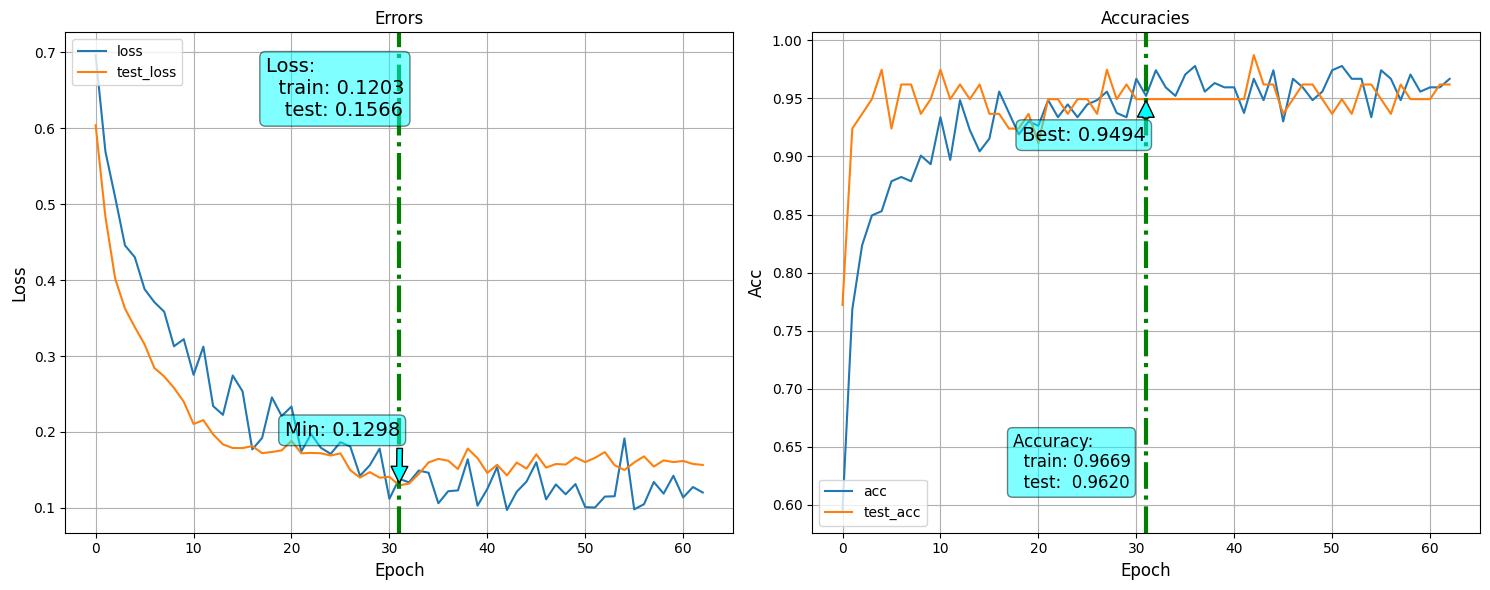

In [18]:
fn_plot_torch_hist(loss_df)

|Type|Result|
|-----|-----|
|BN \| dor1 = 0.05, dor2 = 0.1, dor3 = 0.15| 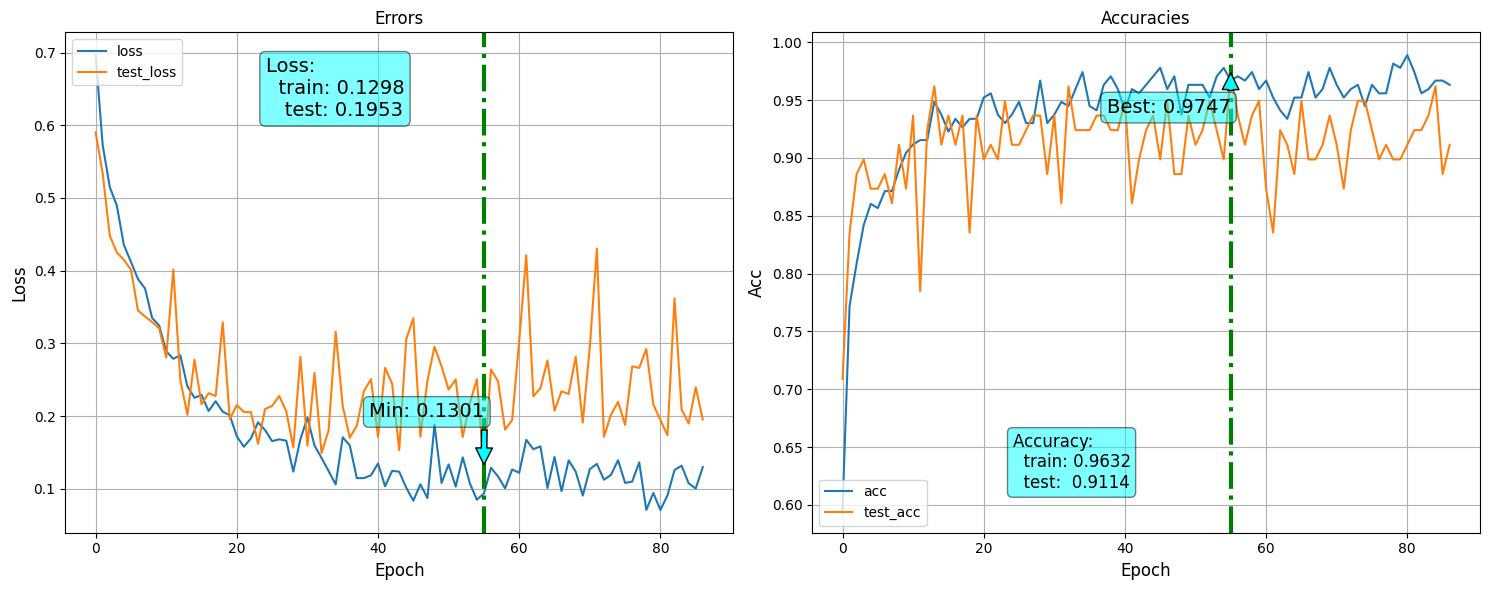|
|BN \| dor1 = 0.05, dor2 = 0.1, dor3 = 0.15 \| model.train() model.eval() |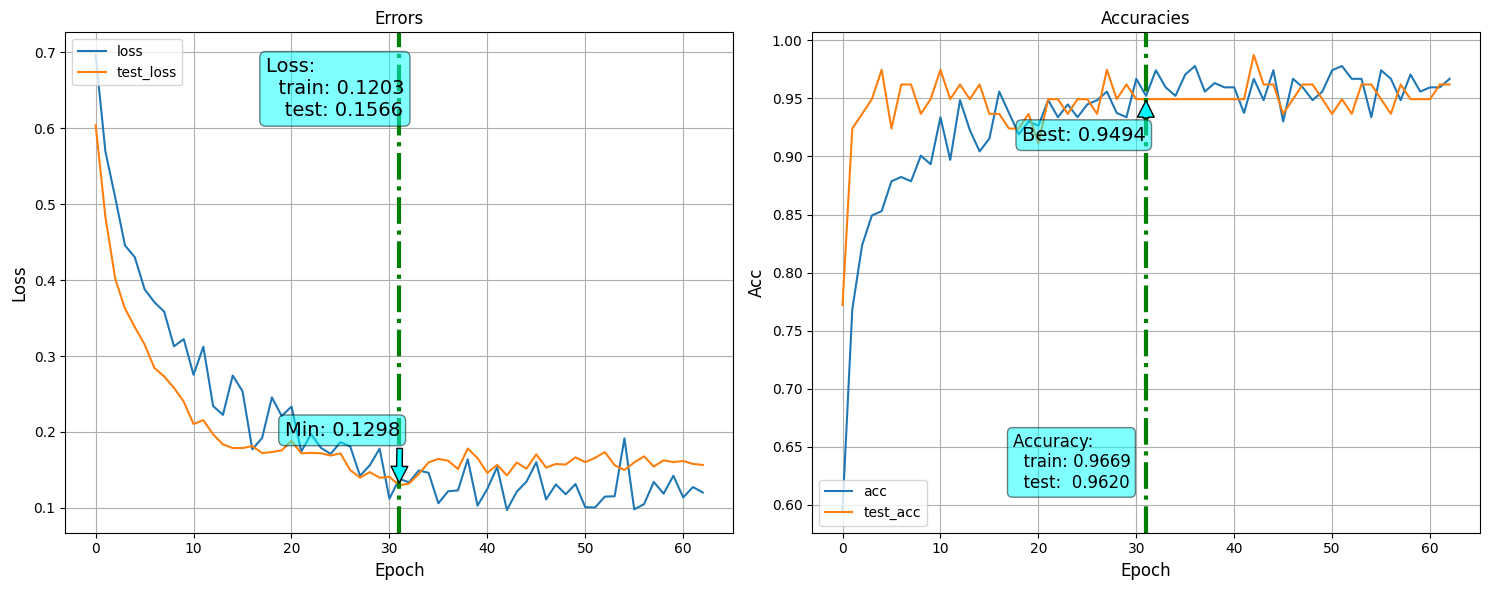|
|BN \| dor1 = 0.17, dor2 = 0.12, dor3 = 0.07 \| model.train() model.eval() |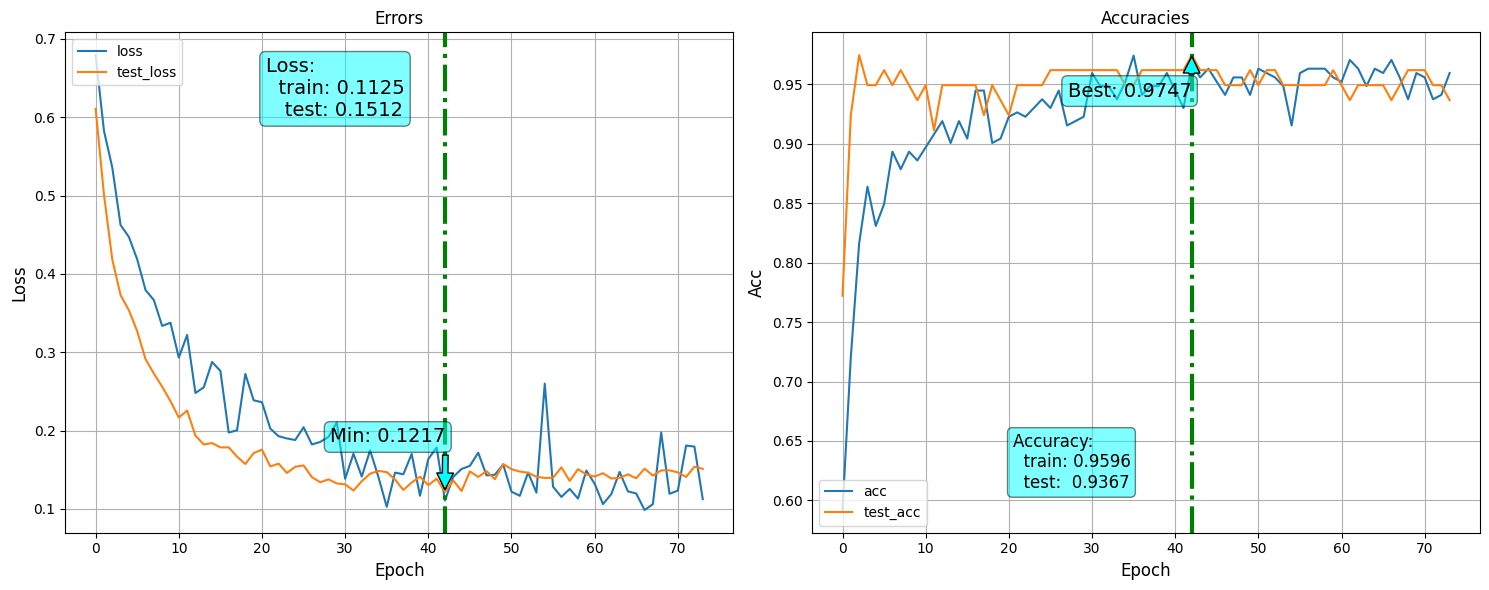|
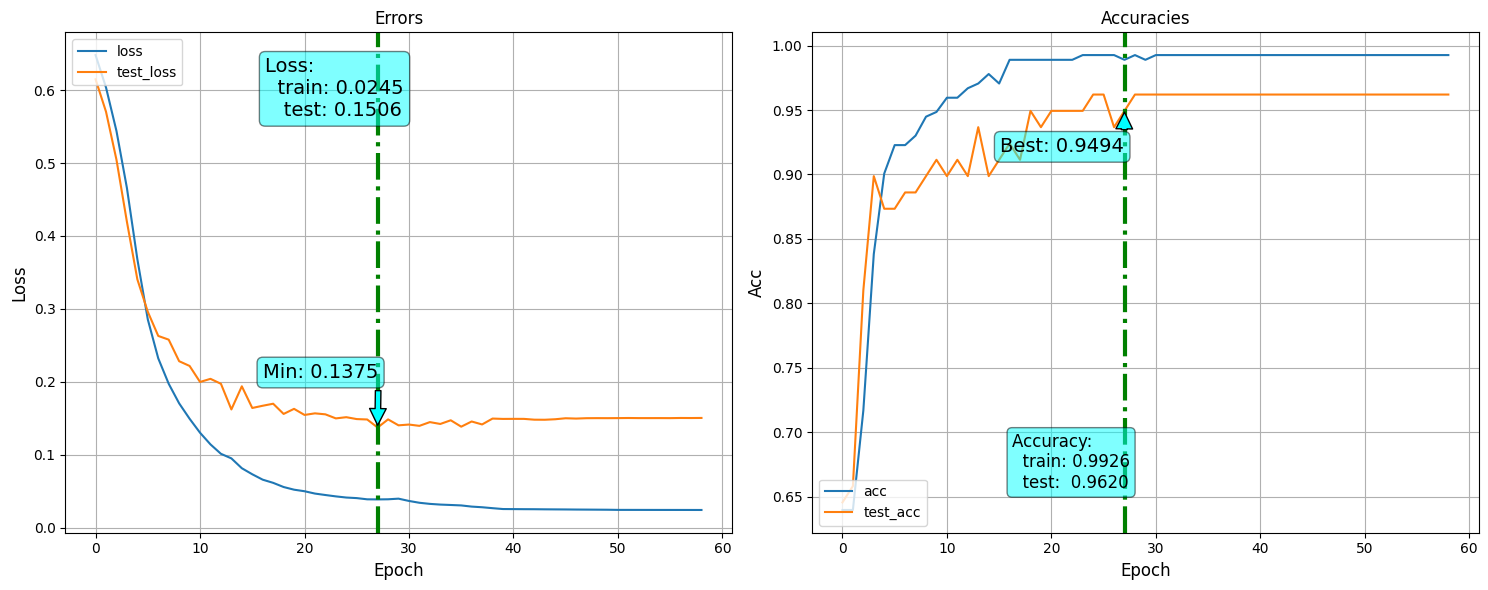

Training Accuracy

In [19]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        98
           1       0.99      0.99      0.99       174

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.99       272
weighted avg       0.99      0.99      0.99       272



In [20]:
train_ds.transformers.encoder.classes_

array(['b', 'g'], dtype=object)

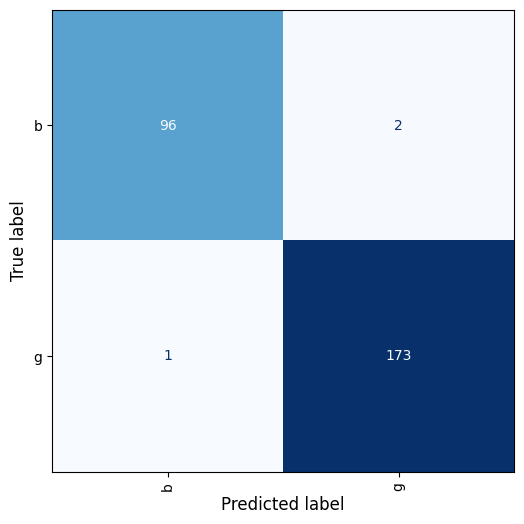

In [21]:
class_names = {k : v for k, v in enumerate(train_ds.transformers.encoder.classes_)}
fn_plot_confusion_matrix(y_train,y_pred, class_names)

Testing Accuracy

In [22]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.94      1.00      0.97        51

    accuracy                           0.96        79
   macro avg       0.97      0.95      0.96        79
weighted avg       0.96      0.96      0.96        79



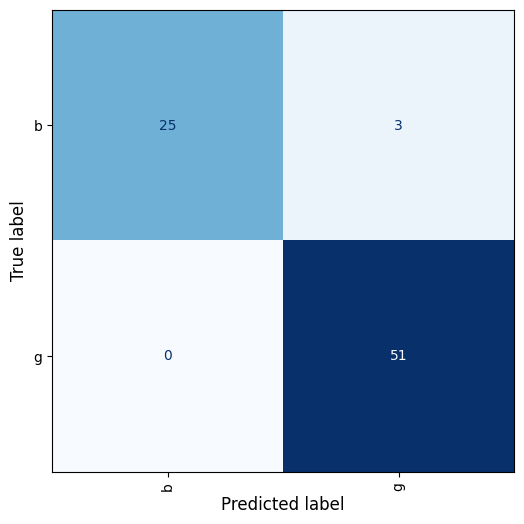

In [23]:
fn_plot_confusion_matrix(y_test, y_pred, class_names)